In [5]:
import sys, os
sys.path.append(os.path.abspath('../data'))
sys.path.append(os.path.abspath('../nnets'))
from dense import DenseManualUpdate as Dense, forward, backward
from csv_data import HousePricesDatasetWrapper
import numpy as np
from optimizer import Optimizer

wrapper = HousePricesDatasetWrapper()
train_data, valid_data, test_data = wrapper.get_flat_datasets()

Downloading...
From: https://drive.google.com/uc?export=download&id=1eWeeYlxNatpXQSsiFwQg2HJeYCTJNj9Z
To: /Users/sanskritiakhoury/Desktop/machine learning/Regularization/house_prices.csv
100%|██████████████████████████████████████| 71.2k/71.2k [00:00<00:00, 3.58MB/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
# Initialize W&B
%env WANDB_SILENT=True

import wandb
wandb.login()

def training_run(epochs, regularization, layers, optimizer, train_data, valid_data, name=None):
    # Initialize a new W&B run
    wandb.init(project="regularization",
               name=name,
               config={"regularization": regularization})

    # Split the training and valid data into x and y
    train_x, train_y = train_data
    valid_x, valid_y = valid_data

    for epoch in range(epochs):
        running_loss = 0
        for i in range(len(train_x)):
            # Get the x and y batches
            x_batch = train_x[i:(i+1)]
            y_batch = train_y[i:(i+1)]
            # Make a prediction
            pred = forward(x_batch, layers, training=True)

            # Run the backward pass
            loss = pred - y_batch
            layer_grads = backward(loss, layers)
            running_loss += np.mean(loss ** 2)

            # Run the optimizer
            optimizer(layer_grads, layers, 1)

        # Calculate and log validation loss
        valid_preds = forward(valid_x, layers, training=False)
        valid_loss = np.mean((valid_preds - valid_y) ** 2)
        train_loss = running_loss / len(train_x)

        # Log training metrics
        wandb.log({
            "valid_loss": valid_loss,
            "epoch": epoch,
            "train_loss": train_loss,
        })

    # Mark the run as complete
    wandb.finish()

env: WANDB_SILENT=True


In [7]:
def test_loss(layers, test_data):
    test_x, test_y = test_data
    preds = forward(test_x, layers, training=False)
    loss = np.mean((preds - test_y) ** 2)
    return loss

In [8]:
class SGDW(Optimizer):
    def __init__(self, lr, decay):
        # Store the learning rate and decay coefficient
        self.lr = lr
        self.decay = decay
        super().__init__()

    def __call__(self, layer_grads, layers, batch_size):
        # Loop through the layer grads.  Reverse the layers to match the grads (from output backward to input).
        for layer_grad, layer in zip(layer_grads, reversed(layers)):
            if layer_grad is None:
                # Account for dropout layers
                continue
            w_grad, b_grad = layer_grad

            # Calculate the gradient update size
            w_update = -self.lr * w_grad
            # Calculate weight decay
            w_update -= self.decay * layer.weights

            # We don't usually decay the bias
            b_update = -self.lr * b_grad

            # Actually do the update
            layer.update(w_update, b_update)

        self.save_vector(layers)

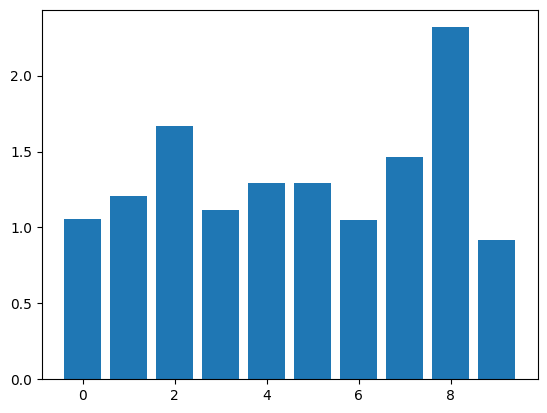

In [9]:
# Two-layer neural network
layers_sgd = [
    Dense(7, 10),
    Dense(10, 1, activation=False)
]
# No decay is equal to SGD
sgd = SGDW(1e-3, 0)
# Normal SGD
training_run(10, "None", layers_sgd, sgd, train_data, valid_data, name="sgd")

# Plot the final weights
sgd.plot_final_weights()

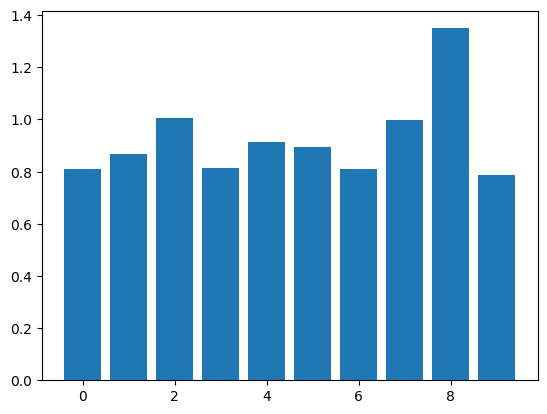

In [10]:
layers_sgdw = [
    Dense(7, 10),
    Dense(10, 1, activation=False)
]

# No decay is equal to SGD
sgd = SGDW(1e-3, 5e-4)
# Weight decay
training_run(10, "Weight Decay", layers_sgdw, sgd, train_data, valid_data, name="sgdw")
sgd.plot_final_weights()

In [11]:
print(f"SGD: {test_loss(layers_sgd, test_data)}")
print(f"SGDW: {test_loss(layers_sgdw, test_data)}")

SGD: 28.32565740885787
SGDW: 107.32555507049128


In [12]:
class Dropout():
    def __init__(self, drop_p):
        # Probability that we'll drop out any single input
        self.drop_p = drop_p
        self.training = True

    def forward(self, input):
        if self.training:
            # Generate a mask of 0s and 1s, using the drop probability
            self.mask = np.random.binomial(1, 1-self.drop_p, input.shape)
        else:
            # No dropout in inference
            self.mask = np.ones_like(input)
        # Apply the mask.  If the mask is 0, the input is set to 0
        return np.where(self.mask, input, 0)

    def backward(self, grad):
        # Use np.where to zero out the gradient where we did dropout
        return None, np.where(self.mask, grad, 0)

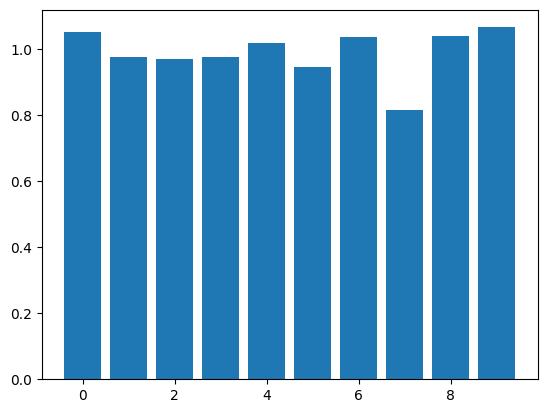

In [13]:
layers_dropout = [
    Dense(7, 10),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-3, 5e-4)
# Weight decay and dropout
training_run(10, "Weight Decay + Dropout", layers_dropout, sgd, train_data, valid_data, name="dropout")
sgd.plot_final_weights()

In [14]:
print(f"SGDW: {test_loss(layers_sgdw, test_data)}")
print(f"SGDW + Dropout: {test_loss(layers_dropout, test_data)}")

SGDW: 107.32555507049128
SGDW + Dropout: 13.244365053084683


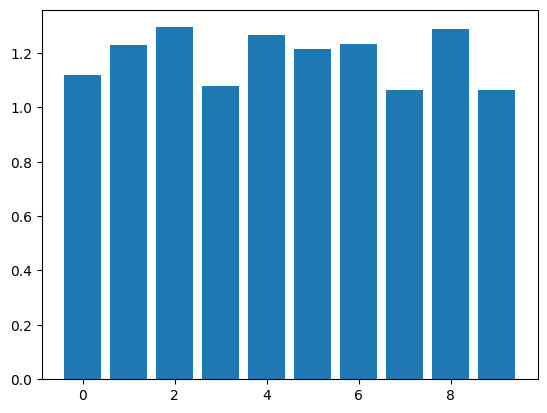

In [15]:
layers_early = [
    Dense(7, 10),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-3, 5e-4)
# Weight decay and dropout
training_run(4, "Early Stopping", layers_early, sgd, train_data, valid_data, name="early_stopping")
sgd.plot_final_weights()

In [16]:
print(f"SGDW + Dropout: {test_loss(layers_dropout, test_data)}")
print(f"SGDW + Dropout + Early Stopping: {test_loss(layers_early, test_data)}")

SGDW + Dropout: 13.244365053084683
SGDW + Dropout + Early Stopping: 15.488170569363836


In [17]:
class DenseResidualConnection(Dense):
    """
    Dense layer with a residual connection
    """
    def forward(self, x):
        output = super().forward(x)
        return x + output # Sum input with output

    def backward(self, grad):
        param_grads, out_grad = super().backward(grad)
        # Sum incoming gradient with calculated gradient
        return param_grads, grad + out_grad

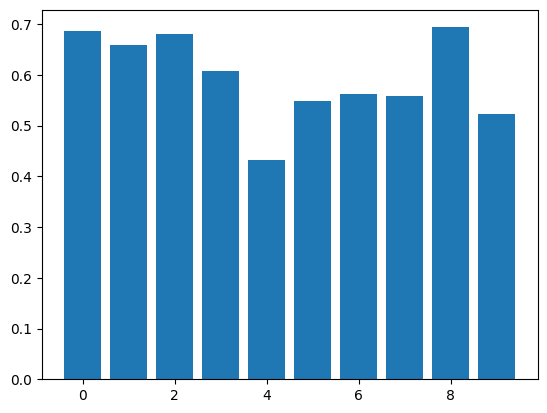

In [18]:
layers_resid = [
    Dense(7, 10),
    DenseResidualConnection(10, 10),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-4, 5e-4)
# Weight decay and dropout
training_run(10, "Residual Connection", layers_resid, sgd, train_data, valid_data, name="residual_connection")
sgd.plot_final_weights()

In [19]:
print(f"SGDW + Dropout + Early Stopping: {test_loss(layers_early, test_data)}")
print(f"Residual Connection: {test_loss(layers_resid, test_data)}")

SGDW + Dropout + Early Stopping: 15.488170569363836
Residual Connection: 26.437392861498786


In [20]:
class LayerNorm():
    def __init__(self, embed_dim, eps):
        self.embed_dim = embed_dim
        # eps is a parameter added for numerical stability when taking a square root
        self.eps = eps

    def forward(self, input):
        # Cache for backward pass
        self.input = input
        # Calculate the mean and standard deviation
        self.mean = np.sum(input, axis=1, keepdims=True) / self.embed_dim
        self.normed = (input - self.mean)
        variance = np.sum(self.normed**2, axis=1, keepdims=True) / self.embed_dim
        self.std = np.sqrt(variance + self.eps)
        inverse_std = 1 / self.std
        # Normalize the input
        self.output = self.normed * inverse_std
        return self.output

    def backward(self, grad):
        """
        This is a long function, but it is just "undoing" the forward pass
        """
        # Find the derivative of numerator (normed)
        # Grad times inverse standard deviation
        grad_normed_1 = grad * 1 / self.std

        # Derivative of denominator (std)
        grad_std = grad * self.normed
        # std is a single number
        grad_std = np.sum(grad_std, axis=1, keepdims=True)
        # Derivative of 1 / std
        grad_std = grad_std * -1 / (self.std**2)

        # Find gradient against the variance
        grad_variance = grad_std * .5 * 1 / self.std

        # Find gradient against normed
        grad_normed_2 = grad_variance * 1 / self.embed_dim
        grad_normed_2 = np.ones_like(self.normed, dtype=self.input.dtype) * grad_normed_2
        grad_normed_2 = grad_normed_2 * 2 * self.normed

        # Combine two gradients against normed
        grad_normed = grad_normed_1 + grad_normed_2

        # Find gradient against mean
        grad_mean = grad_normed * -1
        grad_mean = np.sum(grad_mean, axis=1, keepdims=True)

        # Find gradient against input
        grad_input_1 = grad_normed
        grad_input_2 =  grad_mean * 1 / self.embed_dim
        grad_input_2 = grad_input_2 * np.ones_like(self.input, dtype=self.input.dtype)

        # Combine two gradients against input
        grad_input = grad_input_1 + grad_input_2
        return None, grad_input

In [21]:
class LayerNormAnalytic(LayerNorm):
    def backward(self, grad):
        y_sum = np.sum(grad, axis=1, keepdims=True)
        N = 1 / self.embed_dim
        c1 = N * np.sum(self.output * grad, axis=1, keepdims=True)
        c2 = N * y_sum
        return None, 1/self.std * (grad - c1 * self.output - c2)

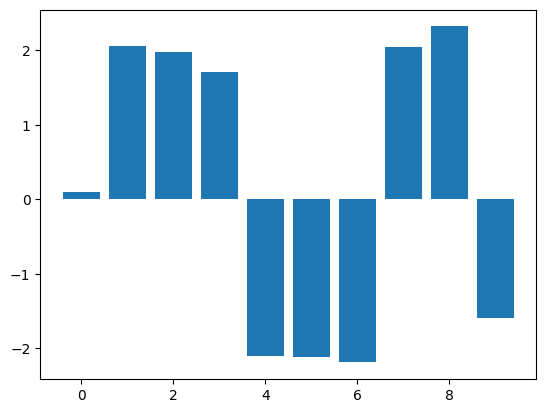

In [22]:
layers_ln = [
    Dense(7, 10),
    DenseResidualConnection(10, 10),
    LayerNorm(10, 1e-6),
    Dropout(.2),
    Dense(10, 1, activation=False)
]

sgd = SGDW(1e-3, 1e-4)
# Weight decay and dropout
training_run(25, "Layer Norm", layers_ln, sgd, train_data, valid_data, name="layer_norm")
sgd.plot_final_weights()

In [23]:
print(f"SGDW + Residual Connection: {test_loss(layers_resid, test_data)}")
print(f"SGDW + Residual Connection + LayerNorm: {test_loss(layers_ln, test_data)}")

SGDW + Residual Connection: 26.437392861498786
SGDW + Residual Connection + LayerNorm: 433.91279386238244
